# Ultimate Take Home Challenge

Part 1 ‑ Exploratory data analysis
The attached logins.json file contains (simulated) timestamps of user logins in a particular
geographic location. Aggregate these login counts based on 15minute
time intervals, and
visualize and describe the resulting time series of login counts in ways that best characterize the
underlying patterns of the demand. Please report/illustrate important features of the demand,
such as daily cycles. If there are data quality issues, please report them.

In [50]:
import json
import datetime
import numpy as np
import pandas as pd
import pandas_profiling
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

from collections import defaultdict
from sklearn.metrics import accuracy_score, recall_score, precision_score, roc_auc_score, make_scorer
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier

In [2]:
logins = pd.read_json('logins.json')

In [3]:
logins.head(5)

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


In [4]:
logins.tail(5)

,login_time
93137,1970-04-13 18:50:19
93138,1970-04-13 18:43:56
93139,1970-04-13 18:54:02
93140,1970-04-13 18:57:38
93141,1970-04-13 18:54:23


In [5]:
logins.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93142 entries, 0 to 93141
Data columns (total 1 columns):
login_time    93142 non-null datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 727.8 KB


In [6]:
logins.describe() 

,login_time
count,93142
unique,92265
top,1970-02-12 11:16:53
freq,3
first,1970-01-01 20:12:16
last,1970-04-13 18:57:38


This data only has login times and a range index. 
The data is only for 3 months (1/1/1970 to 4/13/1970).
There are 1,146 duplicates (<1% of the sample)

As per the case study guidance, we'll visualize the 15 minute segments

In [7]:
# Set index to be the login time
logins.set_index('login_time',inplace = True)
logins['logins'] = 1  # mark each login as a unique event

In [8]:
logins.head()

,logins
login_time,
1970-01-01 20:13:18,1
1970-01-01 20:16:10,1
1970-01-01 20:16:37,1
1970-01-01 20:16:36,1
1970-01-01 20:26:21,1


In [9]:
logins.index  # index is now a Datetime index allowing for resmapling 

DatetimeIndex(['1970-01-01 20:13:18', '1970-01-01 20:16:10',
               '1970-01-01 20:16:37', '1970-01-01 20:16:36',
               '1970-01-01 20:26:21', '1970-01-01 20:21:41',
               '1970-01-01 20:12:16', '1970-01-01 20:35:47',
               '1970-01-01 20:35:38', '1970-01-01 20:47:52',
               ...
               '1970-04-13 18:36:53', '1970-04-13 18:40:31',
               '1970-04-13 18:46:06', '1970-04-13 18:40:40',
               '1970-04-13 18:48:52', '1970-04-13 18:50:19',
               '1970-04-13 18:43:56', '1970-04-13 18:54:02',
               '1970-04-13 18:57:38', '1970-04-13 18:54:23'],
              dtype='datetime64[ns]', name='login_time', length=93142, freq=None)

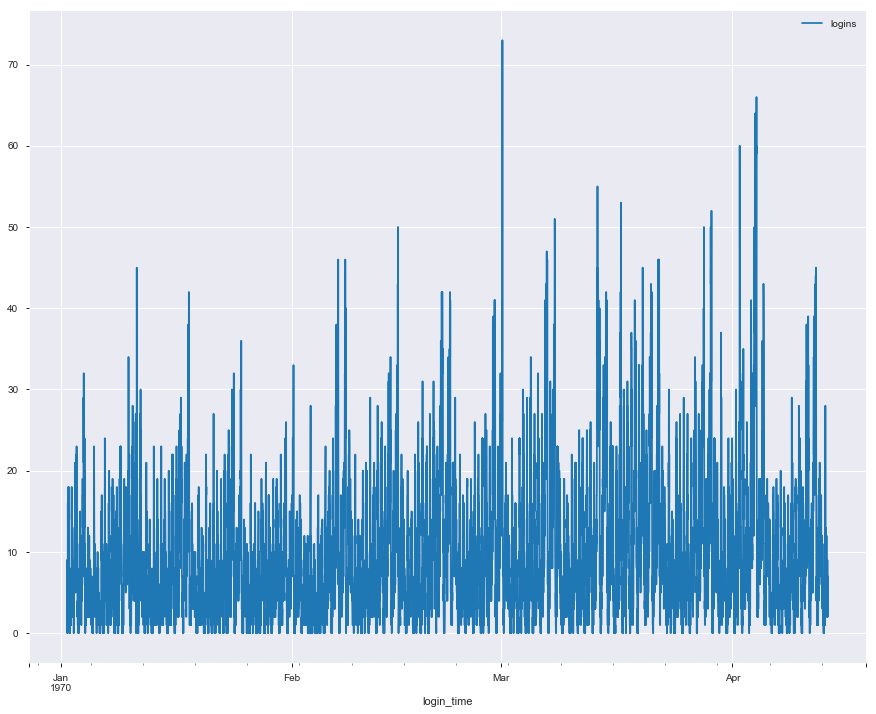

In [10]:
logins.resample('15T').sum().plot(figsize=(15,12))   # sum the # of logins per 15min plot
plt.show()

There appears to be some consistent spikes however it's hard to 
determine an identifiable pattern. The Statsmodel Seasonal Decomposition method 
might help indentify any seasonality in the data sample

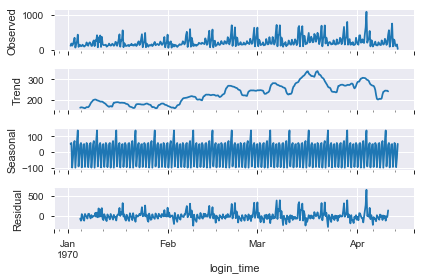

In [11]:
#plt.figure(figsize=(20,20))
decomposition = sm.tsa.seasonal_decompose(logins.resample('6H').sum())
decomposition.plot()
plt.show()

There seems to be a definte rhythm to the data. The seasonal decomposition shows
a consistent spike each month. The trend analysis also shows an steady increase.

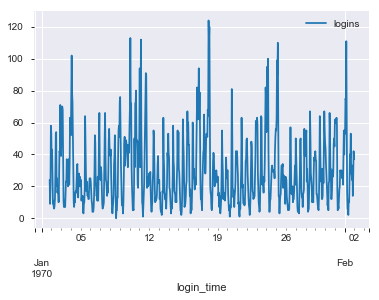

In [12]:
logins.resample('1H').sum()['1970-01-01':'1970-02-01'].plot()
plt.show()

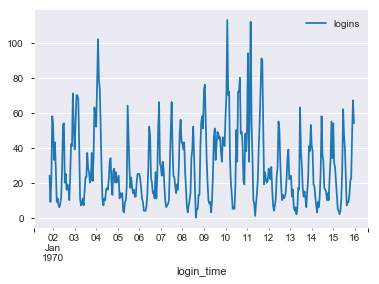

In [13]:
logins.resample('1H').sum()['1970-01-01':'1970-01-15'].plot()
plt.show()

A data spike appears to occur each hour in the data sample. While not all spikes
are equal in height, the consistent spike pattern is visible.

Next, let's see if there's any weekdays more active than others

In [14]:
logins['weekday'] = logins.index.weekday

In [15]:
logins.weekday.value_counts()

5    19377
6    18167
4    15208
3    11960
2    10339
1     9268
0     8823
Name: weekday, dtype: int64

### Part 1 conclusion

As shown by the day of week value counts above, there is also more logins on the 
weekend (Saturday = 5, Sunday = 6, Monday = 0, etc.)

The data is showing 2 trends. First, a daily spike in logins and second, increased 
logins on the weekend.

Data Quality: While the data had about 1 percent of duplicate logins, I assessed 
it to have minimal impacts. Once the data was indexed by date / timestamp, it was
also sorted in the proper sequence.

## Part 2 ‐ Experiment and metrics design

The neighboring cities of Gotham and Metropolis have complementary circadian rhythms: on weekdays, Ultimate Gotham is most active at night, and Ultimate Metropolis is most active during the day. On weekends, there is reasonable activity in both cities.
However, a toll bridge, with a two-way toll, between the two cities causes driver partners to tend to be exclusive to each city. The Ultimate managers of city operations for the two cities have proposed an experiment to encourage driver partners to be available in both cities, by reimbursing all toll costs.
1. What would you choose as the key measure of success of this experiment in encouraging driver partners to serve both cities, and why would you choose this metric?  

**Answer:** The challenge is estimating how much a driver "drives' in Gotham or Metropolis. This can be determined by how much time or how much distance in one city or the other one drives. I think the actualy mileage driven in each city is a better indicator.  First, you have better insights into the actual driver patterns. Second, you get a feel for the types of trips they take across the city lines. As discussed above, drivers focus on one city. If you want them to consistently support both cities then shotting for an approxiate 50/50 support ration for each city would show how well the tolls reimbursement program is working

2. Describe a practical experiment you would design to compare the effectiveness of the proposed change in relation to the key measure of success. Please provide details on:

    1. how you will implement the experiment
    2. what statistical test(s) you will conduct to verify the significance of the observation
    3. how you would interpret the results and provide recommendations to the city operations team along with any caveats.  
    
    
**Answer:** Given that every cab is GPS tracked these days, we should already have the data showing driving patterns. I would establish a baseline for the location and mileage of the drivers in both cities. We need to understand how the tolls are tracked now (I'm assuming it's a surcharge to the the rider pays). The final data is what whether the cabs based in one city are getting riders on their return trip to their "home city". For example, while a Gotham cab might get a fare over to Metropolis, if they don't get a Metropolis fare back to Gotham, the trip might not be worth fare. 

After baselining the information (mileage, location, fares), we would announce the program and track the data. Given daily and weekly traffic patterns on big cities, we would need to run this program for at least 2 - 3 months to notice any new patterns caused by the toll program. We would compare the average mileage driven in each city by a cab driver and test the statistical signifance of a change in our KPI (using a z-score). We would run a 2 tailed test and verify the p-values. 

If we see the average mileage driven in each city becoming closer to 50/50, then we can say that the program is leading to cab driver

Assuming our KPI does change in a positive direction, then we still have to be mindful of the results. We would want to closer to a 50/50 ratio from both cities. Second, we need to understand the costs of the programs versus the benefits. Since Ultimate is funding the tolls, we need find a way to measure the economic impact of people from other cities taking taxis to our city. Finally, we need to see if this change is increasing the average fares / incomes for the cab drivers. Driving a long distance between 2 cities must lead to getter income for the cab driver for this program to be sucessful

## Part 3 ‐ Predictive modeling


Ultimate is interested in predicting rider retention. To help explore this question, we have provided a sample dataset of a cohort of users who signed up for an Ultimate account in January 2014. The data was pulled several months later; we consider a user retained if they were “active” (i.e. took a trip) in the preceding 30 days.

We would like you to use this data set to help understand what factors are the best predictors for retention, and offer suggestions to operationalize those insights to help Ultimate.

The data is in the attached file *ultimate_data_challenge.json*. See below for a detailed description of the dataset. Please include any code you wrote for the analysis and delete the dataset when you have finished with the challenge.

1. Perform any cleaning, exploratory analysis, and/or visualizations to use the provided data for this analysis (a few sentences/plots describing your approach will suffice). What fraction of the observed users were retained?
2. Build a predictive model to help Ultimate determine whether or not a user will be active in their 6th month on the system. Discuss why you chose your approach, what alternatives you considered, and any concerns you have. How valid is your model? Include any key indicators of model performance.
3. Briefly discuss how Ultimate might leverage the insights gained from the model to improve its long-term rider retention (again, a few sentences will suffice).

## Part 3.1 - Exploratory Analysis

In [16]:
# Load JSON file
with open('ultimate_data_challenge.json') as f:
    ultimate = json.load(f)


# Convert to dataframe
ultimate = pd.DataFrame(ultimate)

# Convert the time series to datetimes appropriately
ultimate.signup_date = pd.to_datetime(ultimate.signup_date)
ultimate.last_trip_date = pd.to_datetime(ultimate.last_trip_date)

ultimate.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct
0,3.67,5.0,4.7,1.10,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,True,46.2
1,8.26,5.0,5.0,1.00,Astapor,2014-05-05,Android,2014-01-29,0.0,0,False,50.0
2,0.77,5.0,4.3,1.00,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,False,100.0
3,2.36,4.9,4.6,1.14,King's Landing,2014-06-29,iPhone,2014-01-10,20.0,9,True,80.0
4,3.13,4.9,4.4,1.19,Winterfell,2014-03-15,Android,2014-01-27,11.8,14,False,82.4


## Profile the dataset using pandas_profiling package

In [17]:
# pandas profiling provides 4 sections in an html report inside the notebook
#
# 1. Dataset overview
# 2. Summary info on each column
# 3. heatmap of the column correlation
# 4. dataset head

pandas_profiling.ProfileReport(ultimate)

The following information was gathered from the pandas profiling html report

**1. Summary**
50,00 row, 8719 (1.5%) missing cells, only 8 duplicate rows
avg_rating_of_drivers has 
avg_rating_of_driver has 8122 (16.2%) missing values
surge_pct has 34409 (68.8%) zeros
trips_in_first_30_days has 15390 (30.8%) zeros
weekday_pct has 9203 (18.4%) zeros


**# 2. Summary info on each column in html report with corresponding stats and histrogram**

Each data column is heavily skewed so we'll do box plots below to assess the outliers 

**# 3. Heatmap of the column correlation**

While there is some positive and negative correlation shown in the heatmap above, there are no high (> +/- .75) items


In [18]:
ultimate.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct
0,3.67,5.0,4.7,1.10,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,True,46.2
1,8.26,5.0,5.0,1.00,Astapor,2014-05-05,Android,2014-01-29,0.0,0,False,50.0
2,0.77,5.0,4.3,1.00,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,False,100.0
3,2.36,4.9,4.6,1.14,King's Landing,2014-06-29,iPhone,2014-01-10,20.0,9,True,80.0
4,3.13,4.9,4.4,1.19,Winterfell,2014-03-15,Android,2014-01-27,11.8,14,False,82.4


In [19]:
ultimate.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
avg_dist                  50000 non-null float64
avg_rating_by_driver      49799 non-null float64
avg_rating_of_driver      41878 non-null float64
avg_surge                 50000 non-null float64
city                      50000 non-null object
last_trip_date            50000 non-null datetime64[ns]
phone                     49604 non-null object
signup_date               50000 non-null datetime64[ns]
surge_pct                 50000 non-null float64
trips_in_first_30_days    50000 non-null int64
ultimate_black_user       50000 non-null bool
weekday_pct               50000 non-null float64
dtypes: bool(1), datetime64[ns](2), float64(6), int64(1), object(2)
memory usage: 4.2+ MB


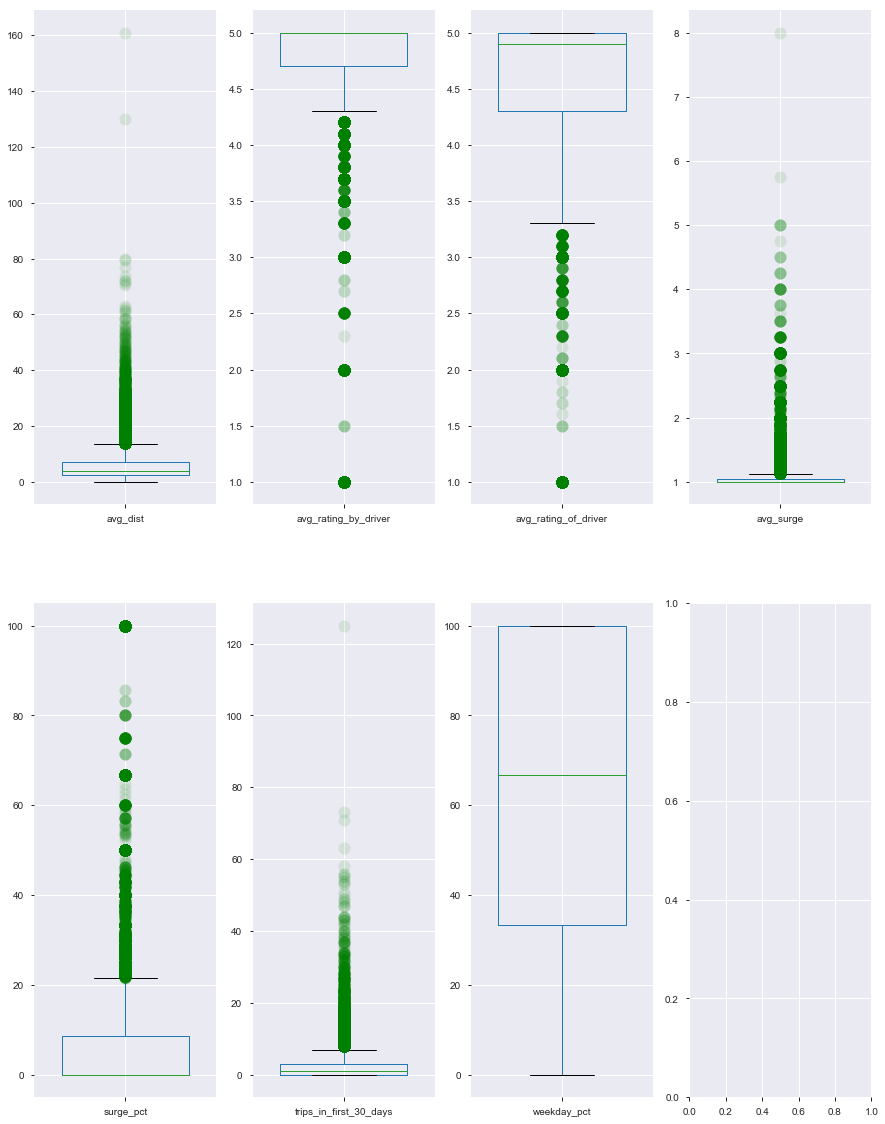

In [20]:
#Make subplotted figure
fig, axes = plt.subplots(2, 4, figsize=(15,20))

#Cycle through all relevant columns
i = 1
for col in ultimate.select_dtypes(include=[np.float64, np.int64]).columns:
    plt.subplot(2, 4, i)
    ultimate[col].plot.box(widths=0.7, flierprops=dict(markerfacecolor='g', markersize=12, alpha=0.1), vert=True)
    i += 1

#Show
plt.show()  

The data is very one-sided. We can remove extreme outliers (> 3.5 standard deviations)
but we first need to check if this will impact a large percentage of the data

In [21]:
def remove_outliers(df, col, num_sd=3.5):
    return df[np.abs(df[col] - df[col].mean()) <= (num_sd * df[col].std())]

In [22]:
outlier_list = ['avg_dist', 'avg_rating_by_driver', 'avg_rating_of_driver', 'avg_surge', 'surge_pct', 
                'trips_in_first_30_days']

for col in outlier_list:
    total = len(remove_outliers(ultimate, col))
    print('%-25s : %i (%2.1f%%)' % (col, total, total*100./len(ultimate)))

avg_dist                  : 49348 (98.7%)
avg_rating_by_driver      : 48847 (97.7%)
avg_rating_of_driver      : 41371 (82.7%)
avg_surge                 : 49193 (98.4%)
surge_pct                 : 48568 (97.1%)
trips_in_first_30_days    : 49220 (98.4%)


Removing the outliers (>3.5 standard deviations) appears to make sense

In [23]:
for col in outlier_list:
    ultimate = remove_outliers(ultimate, col)

ultimate.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38628 entries, 0 to 49998
Data columns (total 12 columns):
avg_dist                  38628 non-null float64
avg_rating_by_driver      38628 non-null float64
avg_rating_of_driver      38628 non-null float64
avg_surge                 38628 non-null float64
city                      38628 non-null object
last_trip_date            38628 non-null datetime64[ns]
phone                     38350 non-null object
signup_date               38628 non-null datetime64[ns]
surge_pct                 38628 non-null float64
trips_in_first_30_days    38628 non-null int64
ultimate_black_user       38628 non-null bool
weekday_pct               38628 non-null float64
dtypes: bool(1), datetime64[ns](2), float64(6), int64(1), object(2)
memory usage: 3.6+ MB


We went from 50K rows down to 38.6K rowws.  The phone column still have ~275 null rows
and it's of limited value in this study so we can drop these nulls as well

In [24]:
ultimate.dropna(inplace=True)    # dropped remaining nulls
ultimate.reset_index(drop=True, inplace=True)

ultimate.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38350 entries, 0 to 38349
Data columns (total 12 columns):
avg_dist                  38350 non-null float64
avg_rating_by_driver      38350 non-null float64
avg_rating_of_driver      38350 non-null float64
avg_surge                 38350 non-null float64
city                      38350 non-null object
last_trip_date            38350 non-null datetime64[ns]
phone                     38350 non-null object
signup_date               38350 non-null datetime64[ns]
surge_pct                 38350 non-null float64
trips_in_first_30_days    38350 non-null int64
ultimate_black_user       38350 non-null bool
weekday_pct               38350 non-null float64
dtypes: bool(1), datetime64[ns](2), float64(6), int64(1), object(2)
memory usage: 3.3+ MB


Final dataset is 38.3K rows. We need to calculate the number of active users

In [25]:
active_users = []
for i in range(len(ultimate)):
    st = pd.Timestamp(ultimate['signup_date'][i]) #get start date
    et = st + pd.Timedelta('181D') #6 months later
    at = et - pd.Timedelta('30D') #set point 30 days prior
    if at <= pd.Timestamp(ultimate['last_trip_date'][i]) <= et:
        active_users.append([1]) # now that the active condition has been met, set active user to 1
    else:
        active_users.append([0])

In [26]:
df1 = pd.DataFrame(active_users,columns= ['active_users'])

In [27]:
df1['active_users'].value_counts()

0    27712
1    10638
Name: active_users, dtype: int64

In [28]:
# 10,638 active users / 50,000 original users ~21%
(10638/50000) * 100

21.276

**Part 3.2**
Build a predictive model  to determine which users will be active 6 months after initially signing up. 

Let's review our cleaned data set

In [29]:
# Combine the original ultimate dataset with the active users (DF1)

df_merge = pd.concat([ultimate,df1],axis=1)

In [30]:
df_merge.to_excel('ultimate_with_active.xlxs')

In [31]:
df_merge.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38350 entries, 0 to 38349
Data columns (total 13 columns):
avg_dist                  38350 non-null float64
avg_rating_by_driver      38350 non-null float64
avg_rating_of_driver      38350 non-null float64
avg_surge                 38350 non-null float64
city                      38350 non-null object
last_trip_date            38350 non-null datetime64[ns]
phone                     38350 non-null object
signup_date               38350 non-null datetime64[ns]
surge_pct                 38350 non-null float64
trips_in_first_30_days    38350 non-null int64
ultimate_black_user       38350 non-null bool
weekday_pct               38350 non-null float64
active_users              38350 non-null int64
dtypes: bool(1), datetime64[ns](2), float64(6), int64(2), object(2)
memory usage: 3.5+ MB


In [85]:
ultimate.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38350 entries, 0 to 38349
Data columns (total 13 columns):
avg_dist                  38350 non-null float64
avg_rating_by_driver      38350 non-null float64
avg_rating_of_driver      38350 non-null float64
avg_surge                 38350 non-null float64
surge_pct                 38350 non-null float64
trips_in_first_30_days    38350 non-null int64
ultimate_black_user       38350 non-null bool
weekday_pct               38350 non-null float64
city_Astapor              38350 non-null uint8
city_King's Landing       38350 non-null uint8
city_Winterfell           38350 non-null uint8
phone_Android             38350 non-null uint8
phone_iPhone              38350 non-null uint8
dtypes: bool(1), float64(6), int64(1), uint8(5)
memory usage: 2.3 MB


We can drop the time columns as they are no longer needed

In [32]:
df_merge.drop(['last_trip_date', 'signup_date'], axis=1, inplace=True)

We must transform the two categorical columns (phone, city) into dummy columns to use
machine learing.

In [33]:
df_merge = pd.get_dummies(df_merge, drop_first=False)
df_merge.columns

Index(['avg_dist', 'avg_rating_by_driver', 'avg_rating_of_driver', 'avg_surge',
       'surge_pct', 'trips_in_first_30_days', 'ultimate_black_user',
       'weekday_pct', 'active_users', 'city_Astapor', 'city_King's Landing',
       'city_Winterfell', 'phone_Android', 'phone_iPhone'],
      dtype='object')

In [35]:
df_merge.to_excel('ultimate_with_active_with_dummies.xlsx')

Our target variable is the 'is_active' column. The other 13 columns are predictor
variables

In [36]:
# Prep data
# Define the target and feature variables
target = "active_users"
feature_cols = df_merge.columns[df_merge.columns != target]

# Create X and Y variables
X = df_merge[feature_cols]
Y = df_merge[target]

In [37]:
X.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct,city_Astapor,city_King's Landing,city_Winterfell,phone_Android,phone_iPhone
0,3.67,5.0,4.7,1.10,15.4,4,True,46.2,0,1,0,0,1
1,8.26,5.0,5.0,1.00,0.0,0,False,50.0,1,0,0,1,0
2,0.77,5.0,4.3,1.00,0.0,3,False,100.0,1,0,0,0,1
3,2.36,4.9,4.6,1.14,20.0,9,True,80.0,0,1,0,0,1
4,3.13,4.9,4.4,1.19,11.8,14,False,82.4,0,0,1,1,0


In [38]:
Y.head()

0    0
1    0
2    0
3    1
4    0
Name: active_users, dtype: int64

**Machine Learning Application:**  The Random Forest algorithm works well across a
variety of data science problem. It does a good job identifying the predictive 
features of a dataset however additional modeling is required to determine how 
the most predictive features actual impact the results. Typically, a linear regression
can be performed using the predictive features to determine their coefficients.

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)
print (X_train.shape, y_train.shape)
print (X_test.shape, y_test.shape)


print(f'The train data has {len(X_train)} rows which is {len(X_train)/len(X) * 100} % of the data')
print(f'The test data has {len(X_test)} rows which is {len(X_test)/len(X) * 100} % of the data')      


(30680, 13) (30680,)
(7670, 13) (7670,)
The train data has 30680 rows which is 80.0 % of the data
The test data has 7670 rows which is 20.0 % of the data


In [42]:
clf = RandomForestClassifier(n_jobs=2, random_state=0)
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=2,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [43]:
preds= clf.predict(X_test)

In [44]:
pd.crosstab(y_test, preds, rownames=['Actual Result'], colnames=['Predicted Result'])

Predicted Result,0,1
Actual Result,,
0,4796,762
1,1283,829


**Part 3.3** 
Random Forest model and feature importance

In [51]:
# print evaluation metrics
print("Accuracy: %.2f" % accuracy_score(y_test, preds))
print("Precision: %.2f" % precision_score(y_test, preds))
print("Recall: %.2f" % recall_score(y_test, preds))

Accuracy: 0.73
Precision: 0.52
Recall: 0.39


The accuracy of this intial model is a reasonable starting 73% - additional analyis
is needed to fine tune the model

In [52]:
features = list(zip(X_train, clf.feature_importances_))
features

[('avg_dist', 0.286073574431002),
 ('avg_rating_by_driver', 0.0992329072362915),
 ('avg_rating_of_driver', 0.09306951316189269),
 ('avg_surge', 0.08488091106152784),
 ('surge_pct', 0.1065300623461712),
 ('trips_in_first_30_days', 0.08763855586091848),
 ('ultimate_black_user', 0.023254556643597858),
 ('weekday_pct', 0.15129675314810723),
 ('city_Astapor', 0.013300441761284624),
 ("city_King's Landing", 0.022174055208976137),
 ('city_Winterfell', 0.007132646449383636),
 ('phone_Android', 0.012220507160155474),
 ('phone_iPhone', 0.01319551553069132)]

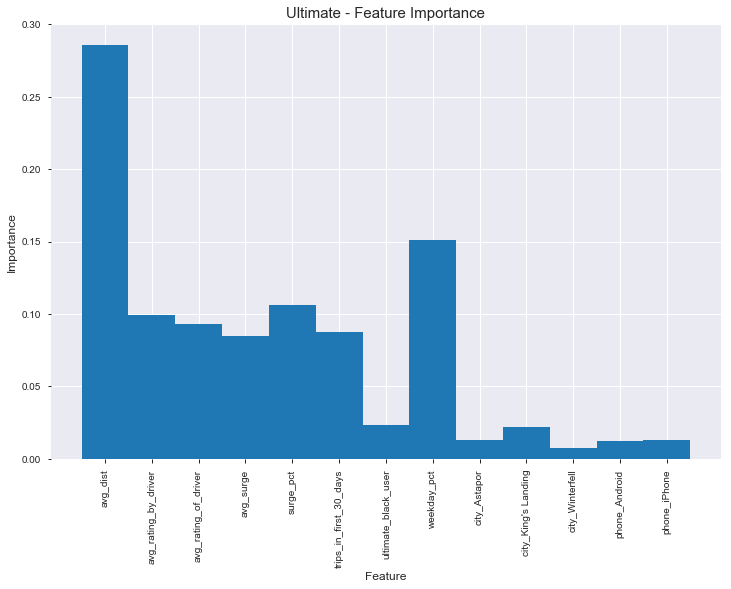

In [69]:
labels, ys = zip(*features)
xs = np.arange(len(labels)) 
width = 1
plt.figure(figsize=(12,8))
plt.bar(xs, ys, width, align='center')
#
plt.xticks(xs, labels, rotation=90) #Replace default x-ticks with xs, then replace xs with labels
plt.title('Ultimate - Feature Importance', fontsize = 15)
plt.xlabel('Feature', fontsize = 12)
plt.ylabel('Importance', fontsize = 12)
#
plt.show()

In [81]:
pd.DataFrame(features,columns = ['Feature', 'Importance']). \
            sort_values('Importance', ascending=False).reset_index(drop=True)

,Feature,Importance
0,avg_dist,0.286074
1,weekday_pct,0.151297
2,surge_pct,0.106530
3,avg_rating_by_driver,0.099233
4,avg_rating_of_driver,0.093070
5,trips_in_first_30_days,0.087639
6,avg_surge,0.084881
7,ultimate_black_user,0.023255
8,city_King's Landing,0.022174
9,city_Astapor,0.013300


From the sorted features importance list above, interstingly, the avg_dist is the most important 
feature. This makes sense that the most active drivers stay enaged. The weekday_pct and surge_puct
are the second and third most important features - also showing the weekday drivers (assumed to
be business users) and those taking trips during surge times are most active.

As with air travel, Ultimate needs to cater to their business users - they are the most active and
often are the most price inelastic customers (within reason).

End of the study